In [1]:
import sys
from __future__ import division, print_function, absolute_import
sys.path.append('/home/ajss/notebooks/deep-learning-projects/')

from tqdm import tqdm
from cnn import ConvolutionalNetwork

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Image
from tensorflow.python.ops import control_flow_ops
from utils import tile_raster_images
import IPython.display
import math
%matplotlib inline

def saveFileForSubmission(predicted_lables,custonFileName='submission.csv',customHeader='ImageId,Label'):
    result = np.c_[range(1,len(predicted_lables)+1),predicted_lables]

    np.savetxt(custonFileName, 
           result.astype(int), 
           delimiter=',', 
           header = customHeader, 
           comments = '', 
           fmt='%u,%u')

(42000, 784)
(42000, 10)


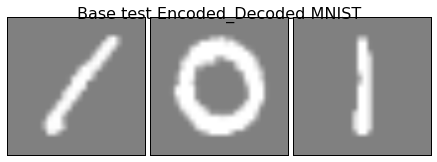

In [2]:
def next_batch(index,data,labels,batch_size=10):
    """Return the next `batch_size` examples from this data set."""
    total = data.shape[0]
    end = index + batch_size
    max_end =  max(0, index + batch_size - total)
    retData =  np.concatenate((data[index:end],data[:max_end]), axis=0)
    retlabel =  np.concatenate((labels[index:end],labels[:max_end]), axis=0)
    return retData,retlabel
def plot_gallery(title, images, n_col, n_row,image_shape = (28, 28)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()   
    
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# read training data from CSV file 
dataTrain = pd.read_csv('./kaggle-mnist/train.csv')
images = dataTrain.iloc[:,1:].values
images = images.astype(np.float)
images = np.multiply(images, 1.0 / 255.0)

labels_flat = dataTrain[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
labels = dense_to_one_hot(labels_flat, labels_count)
#labels = labels_flat #dense_to_one_hot(labels_flat, labels_count)
#labels = labels.astype(np.uint8)

print(images.shape)
print(labels.shape)
for i in range(1):
    batch_xs, batch_ys = next_batch(i*10, images,labels)
    plot_gallery('Base test Encoded_Decoded MNIST',batch_xs[:3],3,1)


CNN - Classification
-------------

In [3]:

# CNN32x24x24
layers="conv2d-32-24-24-1,maxpool-2,conv2d-5-5-32-1,maxpool-2,full-1024,softmax"
n_features = 784
n_classes = 10
original_shape = [28,28,1]
cnn = ConvolutionalNetwork(layers=layers,n_features=n_features,n_classes=n_classes,original_shape=original_shape,keep_prob=0.9)


Building Convolutional layer with 1 input channels                      and 32 5x5 filters with stride 1
Building Max Pooling layer with size 2
Building Convolutional layer with 32 input channels                      and 64 5x5 filters with stride 1
Building Max Pooling layer with size 2
Building fully connected layer with 3136 in units                          and 1024 out units
Building softmax layer with 1024 in units and                      10 out units


In [4]:
# Train DBN
batch_size = 30
epoch = 200
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

interactions = int(math.floor(X_train.shape[0]/batch_size))
print_times = 3
print('CNN')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, X_train,y_train,batch_size)
        cost += cnn.partial_fit(batch_xs,batch_ys)
    if i==0:
        print(i,'cost: ',cost)        
print(i,'cost: ',cost)



  0%|          | 0/200 [00:00<?, ?it/s]

CNN


  0%|          | 1/200 [00:23<1:16:33, 23.08s/it]

0 cost:  188.848459028


100%|██████████| 200/200 [1:15:47<00:00, 22.71s/it]

199 cost:  0.0780121872083


In [5]:
cnn.save_weights('./data-models/cnn/cnn.chp')
names = cnn.layers.split(',')
names

['conv2d-5-5-32-1',
 'maxpool-2',
 'conv2d-5-5-64-1',
 'maxpool-2',
 'full-1024',
 'softmax']

In [6]:
# cnn.restoreWeights('./data-models/cnn/')
y_true, y_pred = np.argmax(y_test, axis=1), cnn.predict(X_test) # Get our predictions
print(classification_report(y_true, y_pred)) # Classification on each digit

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       408
          1       1.00      0.99      0.99       471
          2       0.98      0.99      0.98       420
          3       0.99      0.99      0.99       506
          4       0.98      0.98      0.98       397
          5       0.99      0.99      0.99       339
          6       0.99      0.99      0.99       402
          7       0.99      0.98      0.99       438
          8       0.99      0.99      0.99       403
          9       0.98      0.99      0.99       416

avg / total       0.99      0.99      0.99      4200



In [7]:
# read test data from CSV file 
datatest = pd.read_csv('./kaggle-mnist/test.csv')
imagestest = datatest.iloc[:,:].values
imagestest = imagestest.astype(np.float)
imagestest = np.multiply(imagestest, 1.0 / 255.0)
imagestest.shape

(28000, 784)

In [8]:
a = cnn.predict(imagestest[0:10000]) 
b = cnn.predict(imagestest[10000:20000]) 
c = cnn.predict(imagestest[20000:28000]) 


In [9]:
saveFileForSubmission(np.concatenate([a,b,c]),custonFileName="custoCnn2.csv")